Data Preparation

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

# Load cleaned data
df = pd.read_csv("../data/clean_diabetic_data.csv")

# Binary target
df["readmitted_flag"] = df["readmitted"].apply(lambda x: 1 if x == "<30" else 0)

# Drop original readmitted and identifiers
df = df.drop(columns=["readmitted", "encounter_id", "patient_nbr"])

# Encode categorical columns
categorical_cols = df.select_dtypes(include="object").columns
df[categorical_cols] = df[categorical_cols].apply(lambda col: LabelEncoder().fit_transform(col.astype(str)))

# Handle missing values (if any)
imputer = SimpleImputer(strategy="most_frequent")
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Split features and target
X = df_imputed.drop(columns="readmitted_flag")
y = df_imputed["readmitted_flag"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


Train Models

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Logistic Regression
lr_model = LogisticRegression(max_iter=3000)
lr_model.fit(X_train, y_train)

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

Evaluation

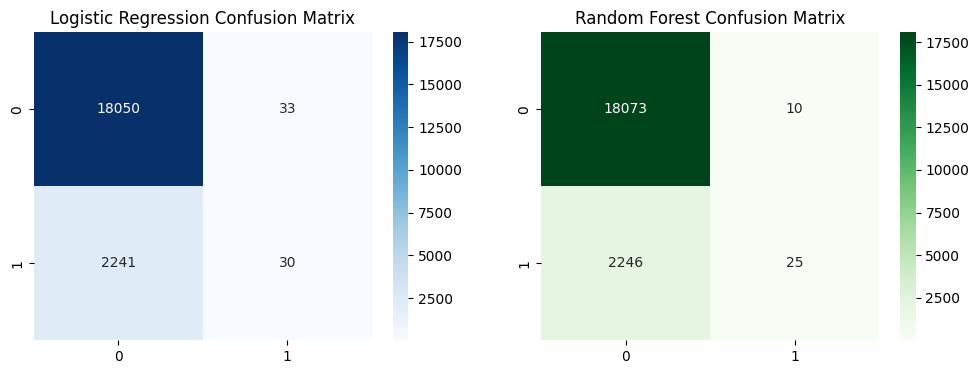

📋 Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18083
           1       0.48      0.01      0.03      2271

    accuracy                           0.89     20354
   macro avg       0.68      0.51      0.48     20354
weighted avg       0.84      0.89      0.84     20354

📋 Random Forest Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18083
           1       0.71      0.01      0.02      2271

    accuracy                           0.89     20354
   macro avg       0.80      0.51      0.48     20354
weighted avg       0.87      0.89      0.84     20354



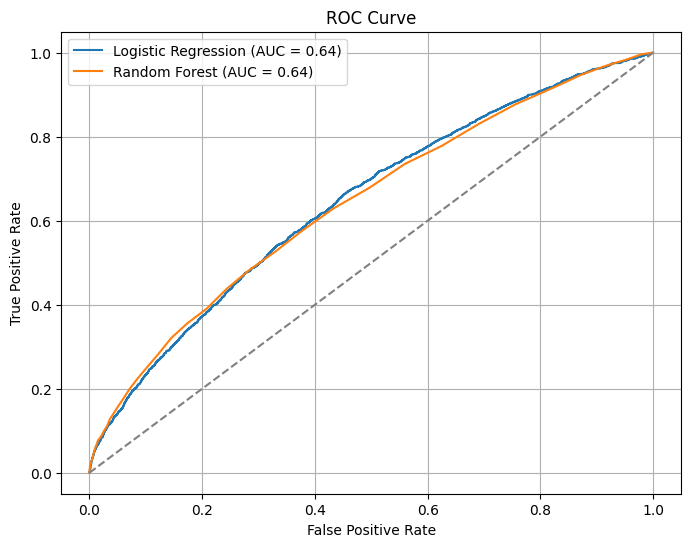

In [5]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Predict probabilities and classes
lr_probs = lr_model.predict_proba(X_test)[:, 1]
rf_probs = rf_model.predict_proba(X_test)[:, 1]

lr_preds = lr_model.predict(X_test)
rf_preds = rf_model.predict(X_test)

# --- Confusion Matrix ---
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, lr_preds), annot=True, fmt="d", cmap="Blues")
plt.title("Logistic Regression Confusion Matrix")

plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test, rf_preds), annot=True, fmt="d", cmap="Greens")
plt.title("Random Forest Confusion Matrix")

plt.show()

# --- Classification Report ---
print("📋 Logistic Regression Report:")
print(classification_report(y_test, lr_preds))

print("📋 Random Forest Report:")
print(classification_report(y_test, rf_preds))

# --- ROC Curve ---
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_probs)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {roc_auc_score(y_test, lr_probs):.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_score(y_test, rf_probs):.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


Feature Importance.

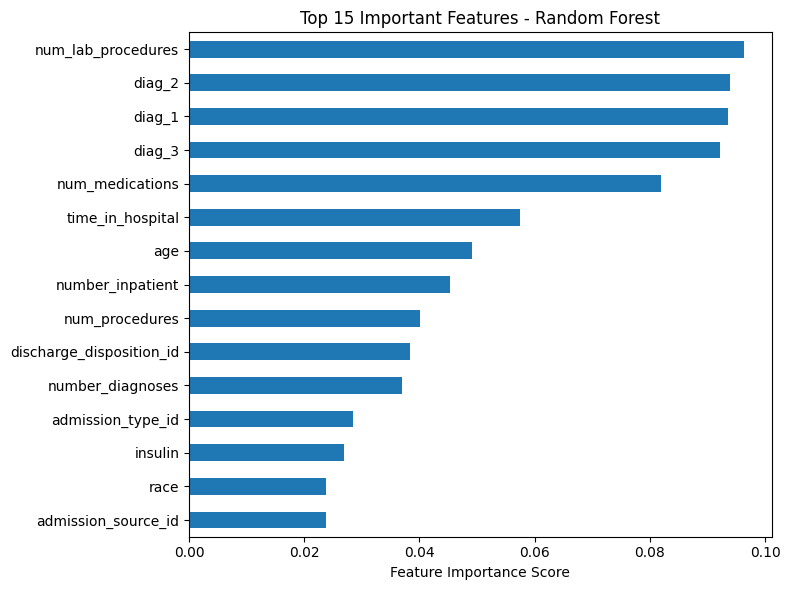

In [6]:
import numpy as np

feat_imp = pd.Series(rf_model.feature_importances_, index=X.columns)
feat_imp.nlargest(15).sort_values().plot(kind="barh", figsize=(8, 6))
plt.title("Top 15 Important Features - Random Forest")
plt.xlabel("Feature Importance Score")
plt.tight_layout()
plt.show()
